In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import sys

sys.path.insert(0, "python")
from network import *
from protocols import *
from adversary import *
from simulator import *
from experiments import run_and_eval, run_experiment

In [3]:
def shorten_protocol_name(x: str):
    val = x.replace("Protocol", "").replace("spreading_proba", "p")
    val = val.split("broadcast")[0][:-1].replace("(", ": ")
    if val[-1] == ",":
        val = val[:-1]
    return val

In [4]:
nw_generator = NodeWeightGenerator("random")
ew_generator = EdgeWeightGenerator("normal")

# Dandelion example

net = Network(nw_generator, ew_generator, num_nodes=1000, k=20)

In [ ]:
seed = 32
net = Network(nw_generator, ew_generator, num_nodes=10, k=2, seed=seed)

In [ ]:
np.mean(list(dict(net.graph.degree).values()))

In [ ]:
tor = TOREnhancedProtocol(net, 1, 2, broadcast_mode="all", seed=seed)

In [ ]:
np.mean(list(dict(net.graph.degree).values()))

In [ ]:
tor.tor_network

In [ ]:
tor.tor_network

In [ ]:
np.random.seed(seed)
np.random.random(3)

In [ ]:
np.random.random(3)

In [ ]:
msg = Message(0)
adv = Adversary(tor, 0.1)

In [ ]:
msg.queue

In [ ]:
msg.process(tor, adv)

In [ ]:
list(net.graph.neighbors(4))

In [ ]:
alma

In [ ]:
dp = DandelionProtocol(net, 0.5)

In [ ]:
dp.anonymity_network.num_edges

dp = DandelionPlusPlusProtocol(net, 0.5)

nx.draw(dp.anonymity_graph, node_size=20)

In [ ]:
%%time
adv = Adversary(net, 0.1)
sim = Simulator(dp, adv, 30, verbose=False)
sim.run()

In [ ]:
%%time
evaluator = Evaluator(sim, "first_reach")
print(evaluator.get_report())

In [ ]:
%%time
evaluator = Evaluator(sim, "first_sent")
print(evaluator.get_report())

In [ ]:
%%time
evaluator = Evaluator(sim, "dummy")
print(evaluator.get_report())

# Unittest in the making

In [5]:
import sys, os, pytest

sys.path.insert(0, "%s/python" % os.getcwd())
import networkx as nx
from network import Network, NodeWeightGenerator, EdgeWeightGenerator
from simulator import Simulator, Evaluator
from message import Message
from protocols import BroadcastProtocol, DandelionProtocol, DandelionPlusPlusProtocol
from adversary import Adversary

In [ ]:
### First sent vs First reach test
rnd_node_weight = NodeWeightGenerator("random")
rnd_edge_weight = EdgeWeightGenerator("random")
G = nx.DiGraph()
G.add_nodes_from([1, 2, 3])
G.add_weighted_edges_from([(1, 2, 0.9), (1, 3, 1.84), (2, 3, 1.01)], weight="latency")
print(nx.draw(G, with_labels=True))
net = Network(rnd_node_weight, EdgeWeightGenerator("custom"), graph=G)
protocol = BroadcastProtocol(net, seed=44)
adv = Adversary(net, ratio=0.0, adversaries=[2])
print(adv.nodes)
assert 3 in adv.nodes

# start a message from Node 1
msg = Message(1)
receiver_order = [1, 2, 2, 2]
for i, receiver in enumerate(receiver_order):
    msg.process(protocol, adv)
    print(i, receiver, msg.history)
    assert receiver in msg.history
    # assert len(msg.history) == i + 1

In [ ]:
sim = Simulator(protocol, adv, 1, True)
sim.run(1.0)
for estimator in ["first_reach", "first_sent"]:
    evaluator = Evaluator(sim, estimator)
    results = [
        evaluator.exact_hits,
        evaluator.ranks,
        evaluator.inverse_ranks,
        evaluator.entropies,
    ]
    for i in results:
        print(estimator, i)

[{'estimator': 'first_reach', 'hit_ratio': 0.0, 'inverse_rank': 0.5, 'entropy': 0.0, 'ndcg': 0.6309297535714575, 'message_spread_ratio': 1.0, 'mean_contact_time_quantiles': [0.18000000000000002, 0.36000000000000004, 0.54, 0.7200000000000001, 0.9, 1.07, 1.2400000000000002, 1.4100000000000001, 1.58], 'std_contact_time_quantiles': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'adversary': 'Adversary(ratio=0.00, active=False, use_node_weights=False)', 'protocol': 'BroadcastProtocol(broadcast_mode=all)', 'network': 'Network(nw_mode=random, ew_mode=custom, num_nodes=3, k=-1)'}, {'estimator': 'first_sent', 'hit_ratio': 0.0, 'inverse_rank': 0.5, 'entropy': 0.0, 'ndcg': 0.6309297535714575, 'message_spread_ratio': 1.0, 'mean_contact_time_quantiles': [0.18000000000000002, 0.36000000000000004, 0.54, 0.7200000000000001, 0.9, 1.07, 1.2400000000000002, 1.4100000000000001, 1.58], 'std_contact_time_quantiles': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'adversary': 'Adversary(ratio=0.00, active=Fa

In [7]:
### Dandelion adversary in the making
H = nx.complete_graph(10)
rnd_node_weight = NodeWeightGenerator("random")
rnd_edge_weight = EdgeWeightGenerator("random")
SEED = 43
net = Network(
    rnd_node_weight, EdgeWeightGenerator("unweighted"), graph=H, seed=SEED
)
protocol = DandelionProtocol(net, 1 / 4, broadcast_mode="all", seed=SEED)
adv = Adversary(protocol, 0.2)
msg = Message(0)

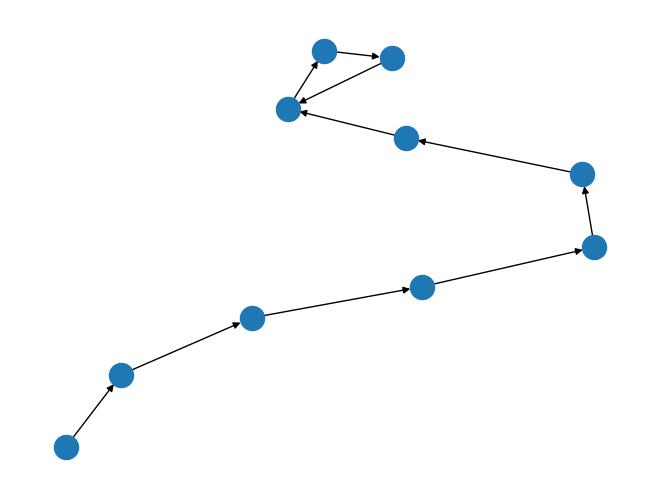

In [9]:
nx.draw(protocol.anonymity_graph)